In [1]:
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import pickle


%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## First, let's load up some data

In [15]:
# Load up full tycho-2 catalog
filename = ('../data/tycho-2/tyc2.dat')
readme = ('../data/tycho-2/ReadMe')
tycho_full = Table.read(filename, format='cds', guess=False, readme=readme)
print "...finished reading data."

# Create the clean tycho-2 catalog
dtype = [('ID','i8'),('ra','f8'),('dec','f8'),('mu_ra','f8'),('mu_dec','f8'), \
         ('mu_ra_err','f8'),('mu_dec_err','f8'),('Bmag','f8'),('Vmag','f8')]

ids = np.intersect1d(np.where(tycho_full['q_pmRA'] >= 0.1), np.where(tycho_full['q_pmDE'] >= 0.1))

t = np.zeros(len(ids), dtype=dtype)
t['ID'] = tycho_full['TYC1'][ids]*100000 + tycho_full['TYC2'][ids]
t['ra'] = tycho_full['RAmdeg'][ids]
t['dec'] = tycho_full['DEmdeg'][ids]
t['mu_ra'] = tycho_full['pmRA'][ids]
t['mu_dec'] = tycho_full['pmDE'][ids]
t['mu_ra_err'] = tycho_full['e_pmRA'][ids]
t['mu_dec_err'] = tycho_full['e_pmDE'][ids]
t['Bmag'] = tycho_full['BTmag'][ids]
t['Vmag'] = tycho_full['VTmag'][ids]


...finished reading data.


In [22]:
# Load up matched pairs
filename = '../data/tycho-2/tycho-2_tmp.out'
dtype = [('ID_1', 'i8'), ('ID_2', 'i8'), ('TYC_1', 'i8'), ('TYC_2','i8'), ('P_random','f8'), ('P_binary','f8'), ('P_posterior','f8')]
pairs = np.genfromtxt(filename, dtype=dtype)

In [37]:
# Create a bigger dataset with all info I might need
dtype = [('TYC_1', 'i8'), ('TYC_2','i8'), ('ra1','f8'), ('dec1','f8'), ('ra2','f8'), ('dec2','f8'), \
         ('theta','f8'), ('delta_mu','f8'), ('B1','f8'), ('V1','f8'), ('B2','f8'), ('V2','f8'), \
         ('P_random','f8'), ('P_binary','f8'), ('P_posterior','f8')]

pairs_full = np.zeros(len(pairs), dtype=dtype)

pairs_full['TYC_1'] = pairs['TYC_1']
pairs_full['TYC_2'] = pairs['TYC_2']
pairs_full['ra1'] = t['ra'][pairs['ID_1']]
pairs_full['dec1'] = t['dec'][pairs['ID_1']]
pairs_full['ra2'] = t['ra'][pairs['ID_2']]
pairs_full['dec2'] = t['dec'][pairs['ID_2']]
theta = P_random.get_theta_proj_degree(t['ra'][pairs['ID_1']], t['dec'][pairs['ID_1']], t['ra'][pairs['ID_2']], t['dec'][pairs['ID_2']])
pairs_full['theta'] = theta * 3600.0
delta_mu = P_random.get_delta_mu(t['mu_ra'][pairs['ID_1']], t['mu_dec'][pairs['ID_1']], t['mu_ra'][pairs['ID_2']], t['mu_dec'][pairs['ID_2']])
pairs_full['delta_mu'] = delta_mu
pairs_full['B1'] = t['Bmag'][pairs['ID_1']]
pairs_full['V1'] = t['Vmag'][pairs['ID_1']]
pairs_full['B2'] = t['Bmag'][pairs['ID_2']]
pairs_full['V2'] = t['Vmag'][pairs['ID_2']]
pairs_full['P_random'] = pairs['P_random']
pairs_full['P_binary'] = pairs['P_binary']
pairs_full['P_posterior'] = pairs['P_posterior']

print "There are", len(pairs_full), "matched binaries."

There are 8515 matched binaries.


## Now, let's make some pretty, pretty plots


In [32]:
P_binary.generate_binary_set()

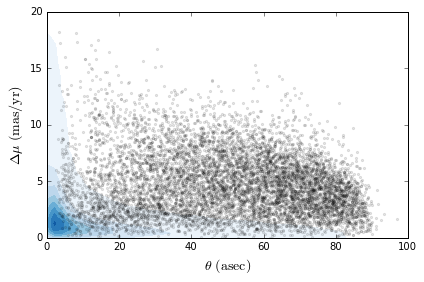

In [38]:
nbins = 50
xmin, xmax = 0.0, 100.0
ymin, ymax = 0.0, 20.0

# Binary probability plot
theta_test = np.linspace(xmin, xmax, nbins)
delta_mu_test = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(theta_test, delta_mu_test)

Z = P_binary.get_P_binary(X.flatten(), Y.flatten())

levels = np.linspace(0.0001, 0.03, 10)
plt.tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')

plt.xlabel(r"$\theta\ ({\rm asec})$", fontsize=14)
plt.ylabel(r"$\Delta \mu\ ({\rm mas/yr})$", fontsize=14)



plt.scatter(pairs_full['theta'], pairs_full['delta_mu'], marker='.', alpha=0.1, color='k')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("../figures/tycho-2_theta_mu.pdf")
#plt.show()

In [41]:
ra_err1 = t['mu_ra_err'][pairs['ID_1']]
dec_err1 = t['mu_dec_err'][pairs['ID_1']]
ra_err2 = t['mu_ra_err'][pairs['ID_2']]
dec_err2 = t['mu_dec_err'][pairs['ID_2']]

delta_mu_err = np.mean(np.sqrt(ra_err1**2 + dec_err1**2 + ra_err2**2 + dec_err2**2))
print "Average proper motion difference uncertainty is", delta_mu_err, "mas/yr"

Average proper motion difference uncertainty is 3.87402739926 mas/yr
